In [2]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import Dataset
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import pandas as pd
import numpy as np
from pickle import load
from tqdm import tqdm
from itertools import product

from utils import one_vs_all, plot_roc, get_prob_and_pred

from sklearn.model_selection import GridSearchCV
from utils import plot_roc

In [3]:
# read the csv files / datasets into a pandas dataframe
train_data = pd.read_csv("pump_train.csv")
test_data = pd.read_csv("pump_test.csv")

In [4]:
train_data.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,12237,30.0,2013-01-23,Government Of Tanzania,107,District Council,39.360880,-10.295705,Zahanati Membe,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional
1,24566,0.0,2013-02-07,Private Individual,0,Edward,32.644074,-3.859265,Kwa Mama Wini,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,functional
2,20536,0.0,2011-07-15,Sawaka,0,DWE,30.999792,-1.721771,Kwasimon,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,30633,200.0,2011-03-25,Government Of Tanzania,2142,Commu,34.060324,-9.335288,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,2993,0.0,2011-02-17,African Muslim Agency,290,District Council,38.862874,-7.165410,Msikitini,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
5,41668,0.0,2013-02-15,Nyitamboka,1229,Nyitamboka,34.349079,-1.630274,Nyitamboka Kitanyita,0,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
6,61839,0.0,2013-02-09,Rwssp,0,DWE,32.586745,-3.815508,Idete,0,...,milky,milky,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
7,62441,0.0,2011-02-21,Government Of Tanzania,75,Centr,39.010886,-7.615327,Nyambili Primary School 2,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
8,53492,0.0,2012-10-18,Member Of Perliament Ahmed Ali,0,Member of Perliament Ahmed Ali,33.165581,-3.796312,Kwa Hima Ganaye,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
9,54314,0.0,2011-08-01,The Desk And Chair Foundat,0,The desk and chair foundat,33.326639,-3.027799,Nguruko,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50490 entries, 0 to 50489
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50490 non-null  int64  
 1   amount_tsh             50490 non-null  float64
 2   date_recorded          50490 non-null  object 
 3   funder                 47396 non-null  object 
 4   gps_height             50490 non-null  int64  
 5   installer              47380 non-null  object 
 6   longitude              50490 non-null  float64
 7   latitude               50490 non-null  float64
 8   wpt_name               50490 non-null  object 
 9   num_private            50490 non-null  int64  
 10  basin                  50490 non-null  object 
 11  subvillage             50175 non-null  object 
 12  region                 50490 non-null  object 
 13  region_code            50490 non-null  int64  
 14  district_code          50490 non-null  int64  
 15  lg

In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,50490.0,37113.857695,21447.241039,0.000000,18517.250000,37027.500000,55636.750000,7.424700e+04
amount_tsh,50490.0,319.158123,2987.517185,0.000000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,50490.0,669.714280,693.123330,-90.000000,0.000000,371.000000,1322.000000,2.770000e+03
longitude,50490.0,34.078591,6.553382,0.000000,33.084409,34.906548,37.178899,4.034519e+01
latitude,50490.0,-5.708336,2.943806,-11.648378,-8.541643,-5.019807,-3.327550,-2.000000e-08
num_private,50490.0,0.459497,10.413455,0.000000,0.000000,0.000000,0.000000,1.402000e+03
region_code,50490.0,15.280511,17.550035,1.000000,5.000000,12.000000,17.000000,9.900000e+01
district_code,50490.0,5.641731,9.668596,0.000000,2.000000,3.000000,5.000000,8.000000e+01
population,50490.0,180.913389,479.854870,0.000000,0.000000,25.000000,215.750000,3.050000e+04
construction_year,50490.0,1301.724520,951.258506,0.000000,0.000000,1986.000000,2004.000000,2.013000e+03


In [7]:
# checking how many different values are there in each column
train_data.nunique()

id                       50490
amount_tsh                  94
date_recorded              348
funder                    1734
gps_height                2409
installer                 1964
longitude                48914
latitude                 48916
wpt_name                 32390
num_private                 62
basin                        9
subvillage               17774
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2085
population                 989
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2583
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [8]:
train_data.shape

(50490, 41)

In [9]:
# Datensatz nach fehlenden Werten untersuchen
train_data.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3094
gps_height                   0
installer                 3110
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 315
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2846
recorded_by                  0
scheme_management         3269
scheme_name              23942
permit                    2591
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

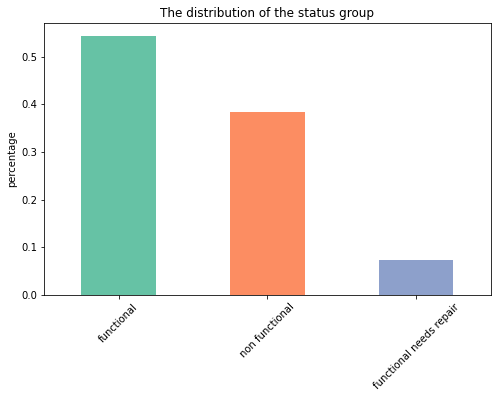

In [10]:
# defining colors for the plots
my_cmap = plt.get_cmap("Set2")
# making the plot
fig = plt.figure(figsize=(8,5))  
train_data.status_group.value_counts(normalize = "true").plot(kind="bar", title="The distribution of the status group", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

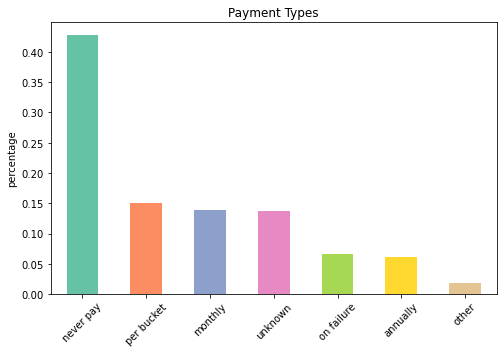

In [11]:
fig = plt.figure(figsize=(8,5))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="bar", title="Payment Types", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

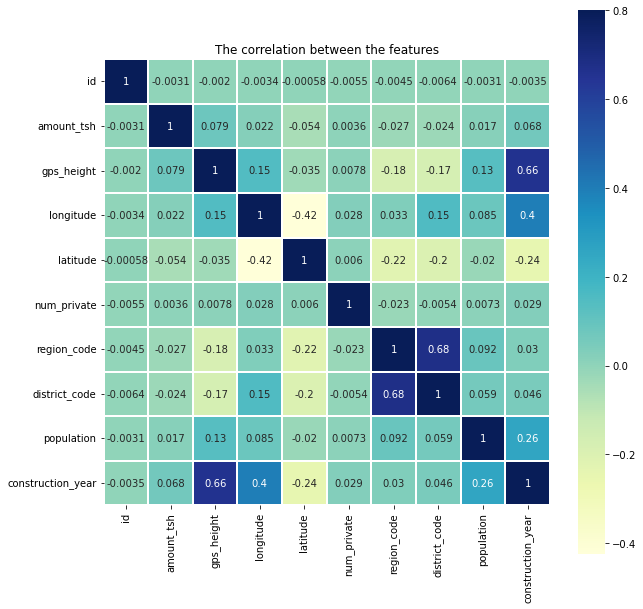

In [12]:
corr=train_data.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('The correlation between the features');

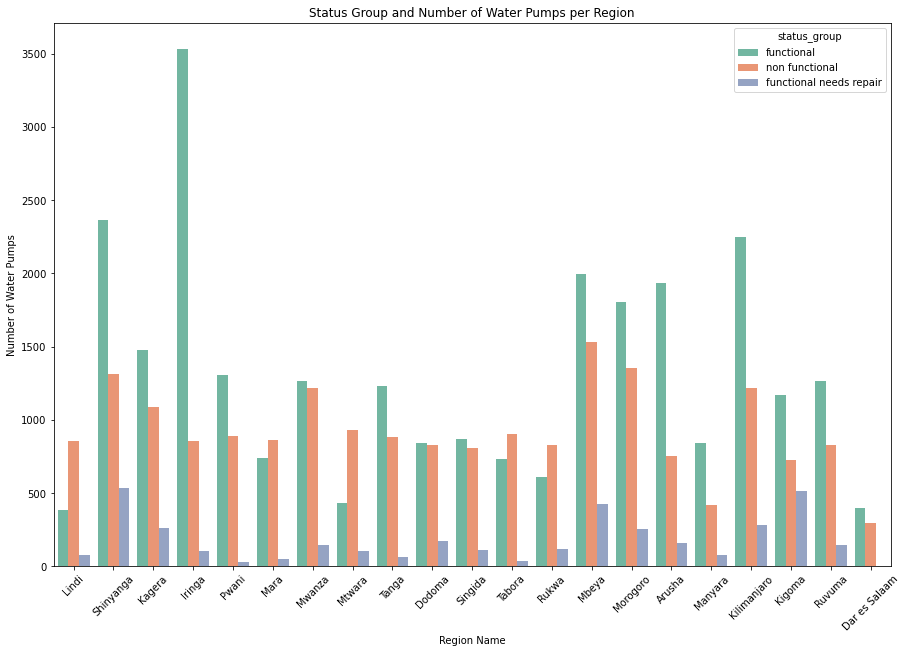

In [13]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='region', hue='status_group', palette="Set2")
plot.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Status Group and Number of Water Pumps per Region')
plt.xticks(rotation=45);
# Quelle: https://github.com/dustiny5/Predictive_Modeling/blob/master/Water_Pump_Best%20-%20Final.ipynb

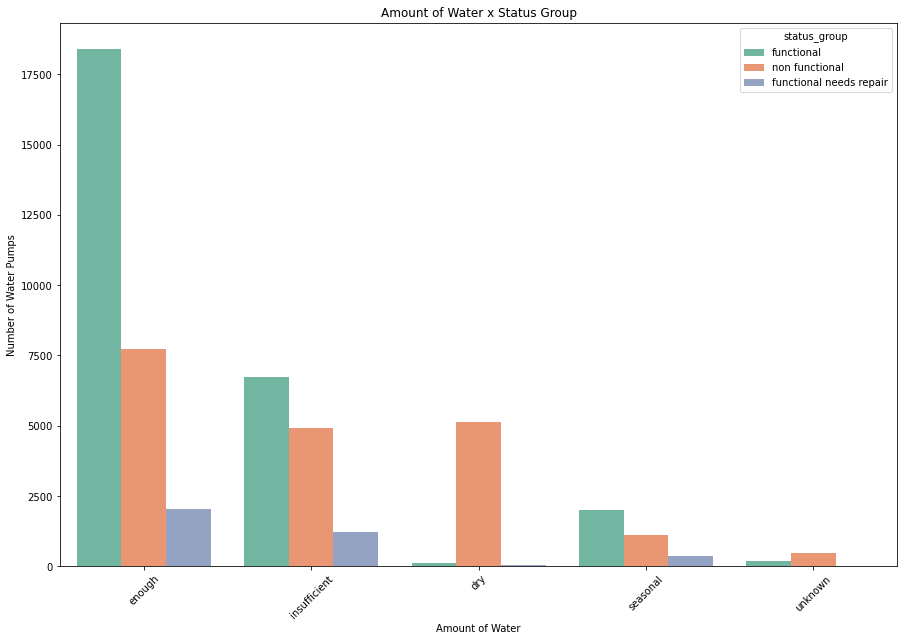

In [14]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='quantity', hue='status_group', palette="Set2")
plot.set(xlabel='Amount of Water', ylabel='Number of Water Pumps', title='Amount of Water x Status Group')
plt.xticks(rotation=45);
# Quelle: https://github.com/dustiny5/Predictive_Modeling/blob/master/Water_Pump_Best%20-%20Final.ipynb

1.29% of the pumps in the dataset are private


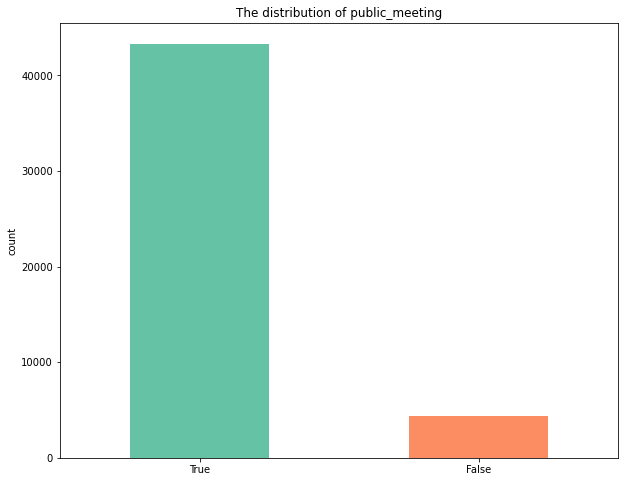

In [15]:
fig = plt.figure(figsize=(10,8))  
train_data.public_meeting.value_counts().plot(kind="bar", title="The distribution of public_meeting", ylabel="count", color=my_cmap.colors)
plt.xticks(rotation=0);
print(f"{len(train_data.num_private[train_data.num_private!=0])/len(train_data):.2%} of the pumps in the dataset are private");

In [16]:
# function for plotting pie charts for each given category
def plot_multiple_pie_by_category(df, category, n_max=None, n_cols=3):
    if n_max is None:
        categories = df[category].unique()
    else:
        categories = df[category].value_counts().index.tolist()[:n_max]
    
    n_rows = len(categories)
    fig = make_subplots(rows=len(categories)//n_cols, cols=n_cols, specs=[[{"type": "pie"}]*n_cols]*(len(categories)//n_cols))
    for i, label in enumerate(categories):
        df_label = df[df[category] == label]
        fig.add_trace(go.Pie(labels=df_label["status_group"].unique(),
        values=df_label["status_group"].value_counts(), 
        name=label, title=f"{label}: {len(df_label)} pumps"), row=i//n_cols+1, col=i%n_cols+1)
    fig.update_layout(height=max(900, n_rows*100), width=1800)
    fig.show()

In [17]:
plot_multiple_pie_by_category(train_data, "funder", n_max=21)

In [18]:
px.box(train_data, x="population", y="status_group")

In [19]:
fig = px.scatter_geo(train_data.sample(1_000), lat="latitude", lon="longitude", color="status_group",  scope="africa", opacity=0.7)
fig.show()